#Spacesence internship task. 
---

> Task : to train a ML model on the EuroSAT land cover classification
dataset.




**Primary comments:** the task was to use Jupyter notebook to perform the task. Unfortunately I have some limitations on my hardware and the use of GPU and CPU, so I will be really thankful if you could consider my work done at Google Colab notebook. 

In [1]:
import tensorflow as tf
from tensorflow import keras
import torch
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, ReLU, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Uploading the data



---


> Firstly we upload the data to the Google Colab enviroment and unzip the file.



In [2]:
!unzip EuroSAT.zip

Archive:  EuroSAT.zip
replace 2750/River/River_479.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N



# Data preprocessing. Data augmntation.


---


> We rescale the pixels of all images, making each value between 0 and 1 as a standard procedure.
We perform data augmentation to reduce the probability of model overfitting.




In [3]:
train_batch_size = 32

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=20,
    zoom_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split = 0.2)

train_dataset = train_datagen.flow_from_directory(directory ='/content/2750', 
                                                 target_size = (64, 64),
                                                 batch_size = train_batch_size,
                                                 color_mode='rgb',
                                                 class_mode = 'binary', 
                                                 subset = 'training')


validation_datagen = ImageDataGenerator(
    rescale = 1./255, 
    validation_split = 0.2)

validation_dataset = validation_datagen.flow_from_directory(directory ='/content/2750', 
                                                 target_size = (64, 64),
                                                 batch_size = train_batch_size,
                                                 color_mode='rgb',
                                                 class_mode = 'binary', 
                                                 subset = 'validation')

Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.





> We split the data on the training, testing and validation.



In [4]:
x_train = np.concatenate([train_dataset.next()[0] for i in range(train_dataset.__len__())])
y_train = np.concatenate([train_dataset.next()[1] for i in range(train_dataset.__len__())])
print(x_train.shape)

img = np.concatenate([validation_dataset.next()[0] for i in range(validation_dataset.__len__())])
lb = np.concatenate([validation_dataset.next()[1] for i in range(validation_dataset.__len__())])

x_test = img[:2700]
y_test = lb[:2700]
print(x_test.shape)

x_valid = img[2700:]
y_valid = lb[2700:]
print(x_valid.shape)

(21600, 64, 64, 3)
(2700, 64, 64, 3)
(2700, 64, 64, 3)


In [5]:
y_test = to_categorical(y_test, 10)
y_train = to_categorical(y_train, 10)
y_valid = to_categorical(y_valid, 10)

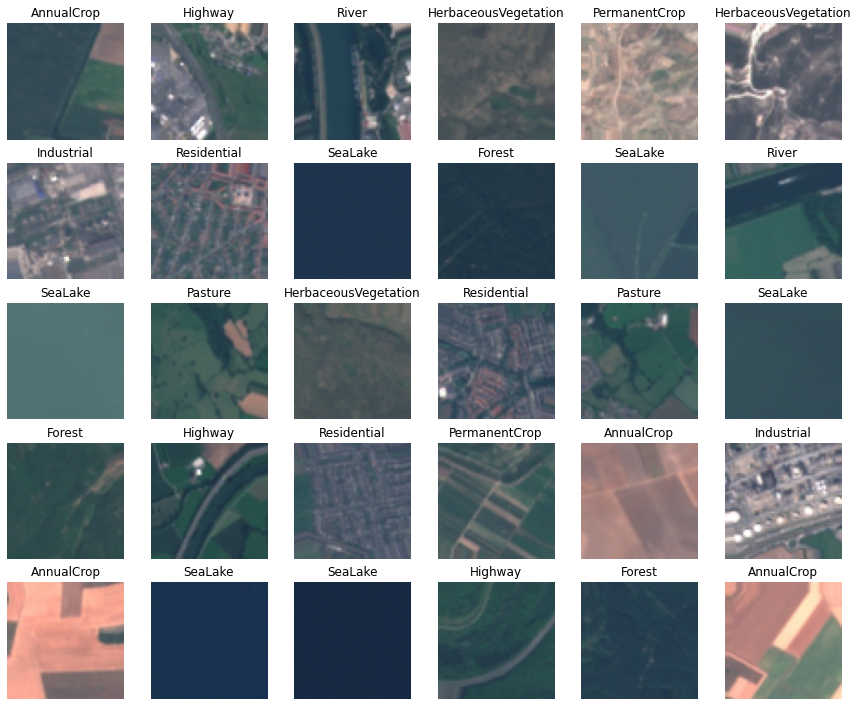

In [6]:
lbl = {0: "AnnualCrop", 
       1: "Forest", 
       2: "HerbaceousVegetation", 
       3: "Highway", 
       4: "Industrial",
       5: "Pasture",
       6: "PermanentCrop",
       7: "Residential",
       8: "River",
       9: "SeaLake"}

images, labels = next(train_dataset)

plt.figure(figsize=(15, 15))
for i in range(30):
    ax = plt.subplot(6, 6, i + 1)
    plt.imshow(images[i])
    plt.title(lbl[labels[i]])
    plt.axis("off")

In [7]:
from keras.backend import clear_session

clear_session()



> Firstly we want to build a small CNN just to look at the performance and make our decisions about architecture.



In [8]:
model = models.Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [9]:
opt = SGD(lr=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=10, 
                    validation_data=(x_valid, y_valid))

Epoch 1/10
675/675 [==============================] - 43s 57ms/step - loss: 2.2966 - accuracy: 0.1113 - val_loss: 2.2944 - val_accuracy: 0.1096
Epoch 2/10
675/675 [==============================] - 38s 56ms/step - loss: 2.2957 - accuracy: 0.1125 - val_loss: 2.2941 - val_accuracy: 0.1126
Epoch 3/10
675/675 [==============================] - 38s 56ms/step - loss: 2.2957 - accuracy: 0.1107 - val_loss: 2.2946 - val_accuracy: 0.1126
Epoch 4/10
675/675 [==============================] - 38s 57ms/step - loss: 2.2958 - accuracy: 0.1111 - val_loss: 2.2956 - val_accuracy: 0.1096
Epoch 5/10
675/675 [==============================] - 39s 57ms/step - loss: 2.2961 - accuracy: 0.1072 - val_loss: 2.2943 - val_accuracy: 0.1126
Epoch 6/10
675/675 [==============================] - 40s 59ms/step - loss: 2.2957 - accuracy: 0.1131 - val_loss: 2.2948 - val_accuracy: 0.1144
Epoch 7/10
675/675 [==============================] - 40s 60ms/step - loss: 2.2958 - accuracy: 0.1106 - val_loss: 2.2942 - val_accuracy:

In [10]:
loss, acc = model.evaluate(x_test, y_test, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

85/85 - 1s - loss: 2.2959 - accuracy: 0.1019 - 1s/epoch - 16ms/step
Restored model, accuracy: 10.19%


In [11]:
model.save("my_model_1.h5")



> The model is obviously underfitting. Let us add the additionsl layers and increase the parameters.



In [13]:
model_CNN = Sequential()

model_CNN.add(Conv2D(filters = 32, kernel_size= (3, 3), padding='same', strides=(1, 1),
                 input_shape=x_train.shape[1:]))
model_CNN.add(Activation('relu'))
model_CNN.add(Conv2D(32, (5, 5)))
model_CNN.add(Activation('relu'))
model_CNN.add(MaxPooling2D(pool_size=(2, 2)))
model_CNN.add(Dropout(0.4))

model_CNN.add(Conv2D(64, (5, 5), padding='same'))
model_CNN.add(Activation('relu'))
model_CNN.add(Conv2D(128, (5, 5)))
model_CNN.add(Activation('relu'))
model_CNN.add(MaxPooling2D(pool_size=(2, 2)))
model_CNN.add(Dropout(0.3))

model_CNN.add(Conv2D(256, (5, 5), padding='same'))
model_CNN.add(Activation('relu'))
model_CNN.add(Conv2D(256, (5, 5)))
model_CNN.add(Activation('relu'))
model_CNN.add(MaxPooling2D(pool_size=(2, 2)))
model_CNN.add(Dropout(0.4))

model_CNN.add(Flatten())
model_CNN.add(Dense(1024))
model_CNN.add(BatchNormalization()) #regularization on the fully connected network
model_CNN.add(Activation('relu'))
model_CNN.add(Dropout(0.5))
model_CNN.add(Dense(10))
model_CNN.add(Activation('softmax'))

In [14]:
model_CNN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 activation_8 (Activation)   (None, 64, 64, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 60, 60, 32)        25632     
                                                                 
 activation_9 (Activation)   (None, 60, 60, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 30, 30, 32)        0         
                                                      

In [15]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 10)

In [16]:
opt = Adam(learning_rate=0.01)

model_CNN.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

history = model_CNN.fit(x_train, y_train, 
                    epochs=50, 
                    validation_data=(x_valid, y_valid),
                    batch_size=32,
                    callbacks=[es])

Epoch 1/50
675/675 [==============================] - 25s 30ms/step - loss: 2.6960 - accuracy: 0.1051 - val_loss: 2.3044 - val_accuracy: 0.1133
Epoch 2/50
675/675 [==============================] - 19s 28ms/step - loss: 2.3102 - accuracy: 0.1093 - val_loss: 2.2952 - val_accuracy: 0.1096
Epoch 3/50
675/675 [==============================] - 18s 26ms/step - loss: 2.2990 - accuracy: 0.1127 - val_loss: 2.2958 - val_accuracy: 0.1019
Epoch 4/50
675/675 [==============================] - 17s 25ms/step - loss: 2.2980 - accuracy: 0.1091 - val_loss: 2.2955 - val_accuracy: 0.1137
Epoch 5/50
675/675 [==============================] - 17s 25ms/step - loss: 2.2973 - accuracy: 0.1096 - val_loss: 2.3004 - val_accuracy: 0.1122
Epoch 6/50
675/675 [==============================] - 17s 25ms/step - loss: 2.2972 - accuracy: 0.1104 - val_loss: 2.2942 - val_accuracy: 0.1152
Epoch 7/50
675/675 [==============================] - 17s 25ms/step - loss: 2.2967 - accuracy: 0.1115 - val_loss: 2.2943 - val_accuracy:

In [17]:
loss, acc = model_CNN.evaluate(x_test, y_test, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

85/85 - 1s - loss: 2.2962 - accuracy: 0.1096 - 676ms/epoch - 8ms/step
Restored model, accuracy: 10.96%


In [18]:
model.save("my_model_2.h5")



> Once again the model is obviously underfitting. We will use now Transfer Learning. We will uses pretrained models of InceptionV3.



In [19]:
ROWS=139
COLS=139

train_gen = train_datagen.flow_from_directory(
    directory ='/content/2750',
    target_size=(ROWS, COLS),
    batch_size = 16,
    subset = 'training'
)

Found 21600 images belonging to 10 classes.


In [20]:
from keras.models import Sequential
from keras.models import Model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras import optimizers, losses, activations, models
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate
from keras import applications

input_shape = (ROWS, COLS, 3)
nclass = len(train_gen.class_indices)

base_model = applications.InceptionV3(weights='imagenet', 
                                include_top=False, 
                                input_shape=(ROWS, COLS,3))
base_model.trainable = False

add_model = Sequential()
add_model.add(base_model)
add_model.add(GlobalAveragePooling2D())
add_model.add(Dropout(0.5))
add_model.add(Dense(nclass, 
                    activation='softmax'))

model = add_model
model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.SGD(lr=1e-4, 
                                       momentum=0.9),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_8 (Dropout)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 10)                20490     
                                                                 
Total params: 21,823,274
Trainable params: 20,490
Non-trainable params: 21,802,784
_________________________________________________________________


/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [21]:
history = model.fit_generator(train_gen, 
                              epochs=3, 
                              shuffle=True, 
                              verbose=True)


<ipython-input-21-d64b5430065f>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


Epoch 1/3
1350/1350 [==============================] - 133s 95ms/step - loss: 1.7252 - accuracy: 0.4385
Epoch 2/3
1350/1350 [==============================] - 129s 95ms/step - loss: 1.1570 - accuracy: 0.6669
Epoch 3/3
1350/1350 [==============================] - 125s 92ms/step - loss: 0.9758 - accuracy: 0.7253


In [22]:
model.save("my_model_3.h5")

In [24]:
from keras.applications.inception_v3 import preprocess_input

test_idg = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split = 0.2)
test_gen = test_idg.flow_from_directory(
    directory ='/content/2750',
    target_size=(ROWS, COLS),
    batch_size = 16,
    shuffle = False,
    class_mode='binary',
    subset = 'validation'
)
len(test_gen.filenames)

Found 5400 images belonging to 10 classes.


5400

In [25]:
predicts = model.predict_generator(test_gen, verbose = True, workers = 2)


<ipython-input-25-8b506fbd1035>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predicts = model.predict_generator(test_gen, verbose = True, workers = 2)


338/338 [==============================] - 13s 34ms/step


In [26]:
import pandas as pd
import os


df = pd.DataFrame(columns=['fname', 'camera'])
df['fname'] = [os.path.basename(x) for x in test_gen.filenames]
df['camera'] = predicts
df.to_csv("sub1.csv", index=False)

In [27]:
df

,fname,camera
0,AnnualCrop_1.jpg,0.276828
1,AnnualCrop_10.jpg,0.814019
2,AnnualCrop_100.jpg,0.997177
3,AnnualCrop_1000.jpg,0.976811
4,AnnualCrop_1001.jpg,0.990437
...,...,...
5395,SeaLake_1534.jpg,0.005862
5396,SeaLake_1535.jpg,0.050335
5397,SeaLake_1536.jpg,0.016027
5398,SeaLake_1537.jpg,0.005498
